# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    %run "fig2.ipynb"

    print('Done')

the variable `GoodDataList` contains the session names
Done


# Part 1

functions that plot each panel.

---

Raster panel

In [2]:
def prep_example_df():
    raster_example = monkey_defs.raster_example
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = monkey_defs.prep_general(dt.load_pyal_data(path))
        df = pyal.restrict_to_interval(df, epoch_fun=monkey_defs.exec_epoch)
        raster_example_df.append(df)
    return raster_example_df

@utility.report
def plot_moneky_fr_raster(df,gs):
    trial=12
    axes = []
    data = []
    for tar in range(monkey_defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data.append(df_.M1_rates[trial])
    data = np.array(data)
    vmin = np.amin(data, axis= (0,1))
    vmax = np.amax(data, axis= (0,1))

    for j,tarData in enumerate(data):
        ax = fig.add_subplot(gs[j])
        axes.append(ax)
        tarData -= vmin
        tarData /= (vmax - vmin)
        ax.imshow(tarData.T, aspect='auto')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_title(r'$ \rightarrow $', rotation=(360/monkey_defs.n_targets)*(j-3), pad=0.5)
    axes[0].set_ylabel(f'Units ($n={tarData.shape[1]}$)')
    return axes

@utility.report
def plot_moneky_vel_ex(df,gs):
    trial=12
    axes = []
    for tar in range(monkey_defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data = df_.pos[trial]
        data -= np.mean(data, axis=0, keepdims=True)
        ax = fig.add_subplot(gs[tar])
        axes.append(ax)
        ax.plot(data[:,0], color='b', label='$X$')
        # ax2 = ax.twinx()
        # utility.phantom_axes(ax2)
        ax.plot(data[:,1], color='r', label='$Y$')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    return axes

3D dynamics panel

In [3]:
@utility.report
def plot_monkey_pc_example(raster_example_df, gs):   
    fig=gs.figure
    
    colors = utility.get_colors(8)
    dfs=[]
    axes=[]
    for i,df in enumerate(raster_example_df):
        rates = np.concatenate(df['M1_rates'].values, axis=0)
        rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
        df_ = pyal.apply_dim_reduce_model(df, rates_model, 'M1_rates', '_pca');
        dfs.append(df_)
        ax = fig.add_subplot(gs[i], projection='3d',fc='None')
        axes.append(ax)
        for tar in range(monkey_defs.n_targets):
            df__ = pyal.select_trials(df_, df_.target_id==tar)
            ex = pyal.get_sig_by_trial(df__,'_pca')
            ex = np.mean(ex, axis=2)[:,:3]
            ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
            ax.view_init(60,-47)

    AllData = dt.get_data_array(raster_example_df, area='M1', model=10)
    data1 = np.reshape(AllData[0,...], (-1,10))
    data2 = np.reshape(AllData[1,...], (-1,10))
    A,B,*_ = dt.canoncorr(data1,data2,fullReturn=True)
    coef_ = [A,B]
    for i,sessionData in enumerate(AllData):
        ax = fig.add_subplot(gs[i+3], projection='3d',fc='None')
        U, _, Vh = linalg.svd(coef_[i], full_matrices=False, compute_uv=True, overwrite_a=False, check_finite=False)
        axes.append(ax)
        for tar in range(8):
            ex = np.mean(sessionData[tar,...], axis=0)
            ex = ex @ U @ Vh
            ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
            ax.view_init(60,-47)

    titles=[r'Monkey $C_L$ (\textit{unaligned})',r'Monkey $M$ (\textit{unaligned})',
            r'Monkey $C_L$ (\textit{aligned})',  r'Monkey $M$ (\textit{aligned})']
    labels = ['PC','PC','CC','CC']
    for i, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel(f'{labels[i]}1', labelpad=-15)
        ax.set_ylabel(f'{labels[i]}2', labelpad=-15)
        ax.set_zlabel(f'{labels[i]}3', labelpad=-15)
        ax.set_title(titles[i], y=.9, loc='center')
    
    #======== add the arrow
    
    ax = fig.add_subplot(gs[2], fc='None')
    ax = utility.phantom_axes(ax)
    ax.arrow(0,0,1,0,length_includes_head=True, width=.005, head_width=.015,head_length=.1, ec='k', fc='k')
    ax.set_ylim([-.1,.1])
    ax.set_xlim([-.5,1.1])
    ax.text(0.5,0.01,'CCA', ha='center', va='bottom')
    ax.text(0.5,-0.01,'(alignment)', ha='center', va='top')
    
    return axes

CCA for the example sessions

In [4]:
@utility.report
def plot_cca_for_ex(ax,):
    defs = monkey_defs
    raster_example = defs.raster_example
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = defs.prep_general(dt.load_pyal_data(path))
        raster_example_df.append(df)
    
    df1, df2 = raster_example_df
    AllData1 = dt.get_data_array(df1, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    AllData2 = dt.get_data_array(df2, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T
    
    # lower bound
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
    AllDataL1 = defs._get_data_array(df1, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    AllDataL2 = defs._get_data_array(df2, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllDataL1.shape,AllDataL2.shape),axis=0)
    CCsL=[]
    for sessionData1,sessionData2 in zip(AllDataL1,AllDataL2):
        r = []
        for n in range(params.n_iter * 10):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T
    
    # upper bound
    AllDataU = dt.get_data_array([df1,df2], monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    n_shared_trial1 = AllDataU.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate(AllDataU):
        r = []
        for n in range(params.n_iter * 10):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,monkey_defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,monkey_defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    x_ = np.arange(1,monkey_defs.n_components+1)
    ax.plot(x_, allCCs, color=params.colors.MainCC, marker = 'o', label=f'Across monkeys')
    ax.plot(x_, CCsU[:,0], color=params.colors.UpperCC, marker = '<', ls='--', label=f'Within monkey1')
    ax.plot(x_, CCsU[:,1], marker = '<', ls='--', label=f'Within monkey2')
    ax.plot(x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':', label=f'Control')


    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,monkey_defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.set_title(f'{defs.areas[2]} Alignment')
    ax.legend(loc=(.55,.67))
    ax.set_ylabel('Canonical correlation')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,monkey_defs.n_components])
    ax.spines['left'].set_bounds([0,1])

Executed: `plot_cca_for_ex` in 4.2s


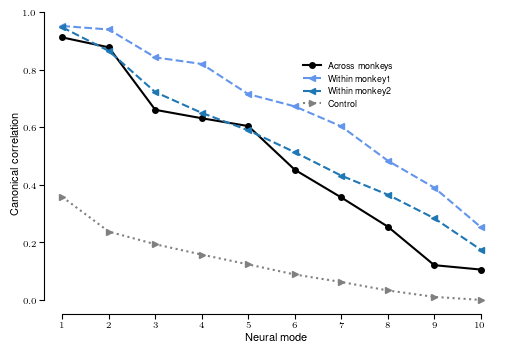

In [5]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig,ax = plt.subplots(dpi=100)
    
    plot_cca_for_ex(ax)
    

---

monkey population CCA plot

In [6]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [7]:
@utility.report
def plot_monkey_cca(ax, ax_hist, full_list_MCx, allDFs_MCx):
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2 = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # lower bound
    len_trial = int(np.round(np.diff(monkey_defs.WINDOW_exec)/monkey_defs.BIN_SIZE))
    single_FileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            single_FileList1.append((I,J))
    n_iter = params.n_iter * 10
    side1df = [allDFs_MCx[i] for i,_ in single_FileList1]
    side2df = [allDFs_MCx[j] for _,j in single_FileList1]
    AllData1 = monkey_defs._get_data_array(side1df, epoch_L=len_trial, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData1_ = monkey_defs._get_data_array(side2df, epoch_L=len_trial, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData1_.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData1_):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T

    # Upper bound
    single_FileList1 = []
    for I, _ in enumerate(full_list_MCx):
        single_FileList1.append(I)
    side1df = [allDFs_MCx[i] for i in single_FileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate(AllData1):
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    x_ = np.arange(1,monkey_defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,monkey_defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,monkey_defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    ax.text(x=monkey_defs.n_components, y=1, s= f'$n={CCsL.shape[1]}$ pairs of sessions\nacross $3$ monkeys',
           ha='right', va='top', fontsize=mpl.rcParams['xtick.labelsize'])
    
    #plot the hist

    bins = np.arange(0,1,0.05)
    ax_hist.xaxis.set_visible(False)
    ax_hist.set_facecolor('None')
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.set_ylim([-.05,1])
    ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'Across ($n={allCCs.shape[1]}$)',
            color=params.colors.MainCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'Within ($n={CCsU.shape[1]}$)',
            color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'Control ($n={CCsL.shape[1]}$)',
            color=params.colors.LowerCC, alpha=.8, orientation='horizontal')
    
    ax_hist.tick_params('y', direction='out')
    ax_hist.set_yticklabels([])
    ax_hist.legend(loc=(0,-.05))

NameError: name 'full_list_MCx' is not defined

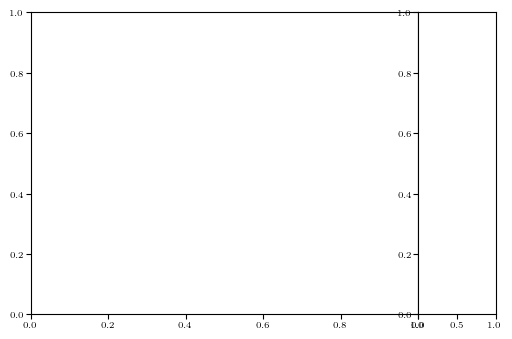

In [8]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1])

    
    # full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca(ax,ax_, full_list_MCx[10:13], allDFs_MCx)
    
    plt.show()

---

decoding for monkeys

In [ ]:
@utility.report
def plot_monkey_decoding(ax, full_list, allDFs):
    defs = monkey_defs
    pairIndexList = []
    for i, (animal1,session1) in enumerate(full_list):
        pairIndexList.append((i,[]))
        for j, (animal2,session2) in enumerate(full_list):
            if animal1 != animal2: continue
            if session1 == session2: continue
            pairIndexList[-1][1].append(j)

    reg_scores = []
    for i, df in enumerate(allDFs):
        AllData, AllVel = defs.get_data_array_and_vel([df], defs.exec_epoch_decode,
                                                      area=defs.areas[2], n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]


        AllData1 = AllData[0,...]
        AllVel1 = AllVel[0,...]
        *_,n_comp = AllData1.shape
        # resizing
        X1 = AllData1.reshape((-1,n_comp))
        # controlling the size
        AllVel1 = AllVel1.reshape((-1,2))
        Y_train_x,Y_train_y = AllVel1.T
        # test the decoder
        x_score=cross_val_score(LinearRegression(),X1,Y_train_x,scoring=defs.custom_r2_scorer, cv=5).mean()
        y_score=cross_val_score(LinearRegression(),X1,Y_train_y,scoring=defs.custom_r2_scorer, cv=5).mean()

        reg_scores.append((i,(x_score,y_score)))
    pop_score_day = []
    for _,scores in reg_scores:
        pop_score_day.append(np.mean(scores))
    pop_score_day = np.array(pop_score_day)

    #=================================
    pairIndex_across = []
    for i, (animal1,session1) in enumerate(full_list):
        pairIndex_across.append((i,[]))
        for j, (animal2,session2) in enumerate(full_list):
            if j <= i: continue
            if animal1 == animal2: continue
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue
            pairIndex_across[-1][1].append(j)
    pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]

    reg_scores_across = []
    for id1, testId in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([allDFs[id1],allDFs[testId]],
                                                      defs.exec_epoch_decode, area=defs.areas[2], n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        # resizing
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel2 = AllVel2.reshape((-1,2))
        AllVel1 = AllVel1.reshape((-1,2))

        # train the decoder
        *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        Y_train_x,Y_train_y = AllVel1.T

        reg_x, reg_y = LinearRegression(), LinearRegression()
        reg_x.fit(U, Y_train_x)
        reg_y.fit(U, Y_train_y)
        # test the decoder
        Y_test_x,Y_test_y = AllVel2.T
        x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
        y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
        reg_scores_across.append((id1,testId,(x_score,y_score)))
    pop_score_across = []
    for _,_,scores in reg_scores_across:
        pop_score_across.append(np.mean(scores))
    pop_score_across = np.array(pop_score_across)

    #=======================================
    reg_latent_scores = []
    for id1, testId in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([allDFs[id1],allDFs[testId]],
                                                      defs.exec_epoch_decode, area=defs.areas[2], n_components=defs.n_components)
        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
        AllData = AllData[...,defs.MAX_HISTORY:,:]
        AllVel = AllVel[...,defs.MAX_HISTORY:,:]


        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        # resizing
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel2 = AllVel2.reshape((-1,2))
        AllVel1 = AllVel1.reshape((-1,2))

        Y_train_x,Y_train_y = AllVel1.T

        reg_x, reg_y = LinearRegression(), LinearRegression()
        reg_x.fit(X1, Y_train_x)
        reg_y.fit(X1, Y_train_y)
        # test the decoder
        Y_test_x,Y_test_y = AllVel2.T
        x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(X2))
        y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(X2))
        reg_latent_scores.append((id1,testId,(x_score,y_score)))
    pop_latent_score = []
    for _,_,scores in reg_latent_scores:
        pop_latent_score.append(np.mean(scores))
    pop_latent_score = np.array(pop_latent_score)

    #=====================================
#     pairIndex_uni = []
#     for i, (animal1,session1) in enumerate(full_list):
#         pairIndex_uni.append((i,[]))
#         for j, (animal2,session2) in enumerate(full_list):
#             if animal1 == animal2: continue
#             if 'Chewie' in animal1 and 'Chewie' in animal2: continue
#             pairIndex_uni[-1][1].append(j)
#     reg_scores_across = []
#     for id1, testList in pairIndex_uni:
#         AllData, AllVel = defs.get_data_array_and_vel([allDFs[id1]], defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)
#         AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
#         AllData1 = AllData[0,...]
#         AllVel1 = AllVel[0,...]
#         X_ = AllData1.reshape((-1,AllData1.shape[-1]))
#         AllVel1 = AllVel1.reshape((-1,2))
#         Y_train_x,Y_train_y = AllVel1.T
#         decode_x, decode_y = LinearRegression(), LinearRegression()
#         decode_x.fit(X_, Y_train_x)
#         decode_y.fit(X_, Y_train_y)
#         for testId in testList:
#             AllData, AllVel = defs.get_data_array_and_vel([allDFs[testId]], defs.exec_epoch, area=defs.areas[2], n_components=defs.n_components)
#             # adding history
#             AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

#             AllData2 = AllData[0,...]
#             AllVel2 = AllVel[0,...]
#             # size matching
#             *_,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)
#             X1 = AllData1[:,:n_trial,:n_time,:n_comp].reshape((-1,n_comp))
#             X2 = AllData2[:,:n_trial,:n_time,:n_comp].reshape((-1,n_comp))
#             AllVel2 = AllVel2[:,:n_trial,:n_time,:].reshape((-1,2))

#             # alignment the decoder
#             A,B,*_ = dt.canoncorr(X1, X2, fullReturn=True)
#             X2_aligned = X2 @ B @ linalg.inv(A) 

#             # test the decoder
#             Y_test_x,Y_test_y = AllVel2.T
#             x_score = defs.custom_r2_func(Y_test_x, decode_x.predict(X2_aligned))
#             y_score = defs.custom_r2_func(Y_test_y, decode_y.predict(X2_aligned))
#             reg_scores_across.append((id1,testId,(x_score,y_score)))
#     pop_score_uni = []
#     for _,_,scores in reg_scores_across:
#         pop_score_uni.append(np.mean(scores))
#     pop_score_uni = np.array(pop_score_uni)


#======================== PLOTTING

    bins = np.arange(0,1,0.05)
    ax.hist(pop_score_across, bins=bins, density=True, label=r'Across (\textit{aligned})',
            alpha=.8, color=params.colors.MainCC)
    ax.hist(pop_latent_score, bins=bins, density=True, label=r'Across (\textit{unaligned})',
            alpha=.8, color=params.colors.LowerCC)
    ax.hist(pop_score_day, bins=bins, density=True, label='Within',
            alpha=.8, color=params.colors.UpperCC)
    # ax.hist(pop_score_uni, bins=bins, density=True, label='Universal',
    #         alpha=.8, color=params.colors.UniversalDecoder)

    ax.set_xlabel('Prediction accuracy ($R^2$)')
    ax.set_ylabel('Probability density', labelpad=1)
    ax.set_yticks([])
    ax.set_xlim([-.05,1])
    ax.legend(loc=(0,.7))
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,1])

NameError: name 'full_list_MCx' is not defined

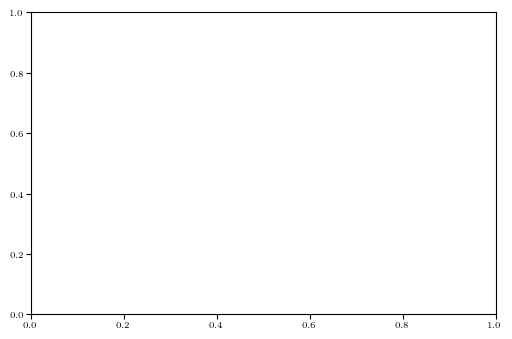

In [9]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()

    
    # full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_decoding(ax, full_list_MCx[10:13], allDFs_MCx)
    
    plt.show()

---

Mouse CCA plot

In [10]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [11]:
@utility.report
def plot_mouse_cca(ax, ax_hist, allDFs_M1):
    defs = mouse_defs
    
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, (df2) in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]
    AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
    AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # upper bound
    AllData1 = dt.get_data_array(allDFs_M1, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
    n_iter = params.n_iter * 10
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for sessionData in AllData1:
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # lower bound
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, df2 in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))

    AllData1 = dt.get_data_array(side1df, area=defs.areas[0], model=defs.n_components)
    AllData2 = dt.get_data_array(side2df, area=defs.areas[0], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            time_idx = params.rng.integers(min_time-len_trial)

            data1 = np.reshape(sessionData1_sh[:,:min_trials,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,time_idx:time_idx+len_trial,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T


    #====================================PLOTTING
    
    x_ = np.arange(1,defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Canonical correlation')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    ax.text(x=defs.n_components, y=1, s= f'$n={CCsL.shape[1]}$ pairs of sessions\nacross $4$ mice',
            ha='right', va='top', fontsize=mpl.rcParams['xtick.labelsize'])

    #plot the hist

    bins = np.arange(0,1,0.05)
    ax_hist.xaxis.set_visible(False)
    ax_hist.set_facecolor('None')
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.set_ylim([-.05,1])
    ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'($n={allCCs.shape[1]}$)',
            color=params.colors.MainCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'($n={CCsU.shape[1]}$)',
            color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'($n={CCsL.shape[1]}$)',
            color=params.colors.LowerCC, alpha=.8, orientation='horizontal')
    
    ax_hist.tick_params('y', direction='out')
    ax_hist.set_yticklabels([])
    ax_hist.legend(loc=(0,-0.05))

NameError: name 'allDFs_M1' is not defined

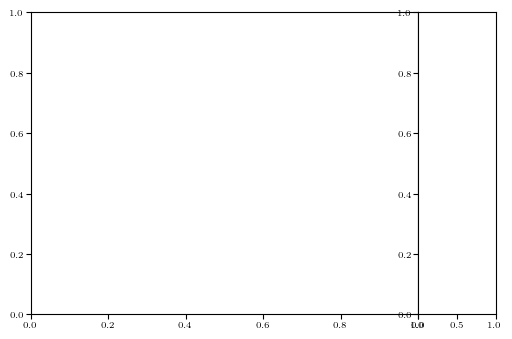

In [12]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1])

    
    # allDFs_M1, _ = get_full_mouse_data()
    
    plot_mouse_cca(ax,ax_, allDFs_M1)
    
    plt.show()

---

plot the behavioural vs CCA

In [13]:
@utility.report
def plot_monkey_cca_corr(ax, allDFs_MCx):
    try:
        os.chdir(params.repoPath / 'monkey')
        %run "_monkey-corr.ipynb"
    finally:
        os.chdir(NBPath)
        
    across_corrs_monkeys = trim_across_monkey_corr(allDFs_MCx)

    pairFileList_monkeys = []
    for I, df1 in enumerate(allDFs_MCx):
        for J, df2 in enumerate(allDFs_MCx):
            if J<=I or df1.monkey[0] == df2.monkey[0]: continue  # to repetitions
            if 'Chewie' in df1.monkey[0] and 'Chewie' in df2.monkey[0]: continue
            pairFileList_monkeys.append((I,J))
            
    side1df = [allDFs_MCx[i] for i,_ in pairFileList_monkeys]
    side2df = [allDFs_MCx[j] for _,j in pairFileList_monkeys]
    AllData1_monkey = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2_monkey = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials_monkey, min_time_monkey,_ = np.min((AllData1_monkey.shape,AllData2_monkey.shape),axis=0)

    CC_corr_monkey=[]
    for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_monkey,AllData2_monkey)):
        data1 = np.reshape(sessionData1[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials_monkey,:min_time_monkey,:], (-1,monkey_defs.n_components))
        k,l = pairFileList_monkeys[i]
        behav = np.array(across_corrs_monkeys[allDFs_MCx[k].session[0]][allDFs_MCx[l].session[0]])
        behav = behav[behav>params.Behav_corr_TH]
        CC_corr_monkey.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
    CC_corr_monkey = np.array(CC_corr_monkey)
    
    #plotting
    ax.scatter(CC_corr_monkey[:,1],CC_corr_monkey[:,0], color=params.colors.MonkeyPts, label='Monkeys', zorder=0)
    ax.set_xlabel('Behavioural correlation')
    ax.set_ylabel('Canonical correlation')
    ax.set_ylim([.53,.85])
    ax.spines['left'].set_bounds([.55,.85])
    ax.set_xlim([.69,.95])
    ax.spines['bottom'].set_bounds([.7,.95])
    ax.legend(loc=(0,.8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_formatter(FormatStrFormatter('$%0.2f$'))

    
@utility.report
def plot_mouse_cca_corr(ax, AllDFs):
    try:
        os.chdir(params.repoPath / 'mouse')
        %run "_mouse-corr.ipynb"
    finally:
        os.chdir(NBPath)
        
    across_corrs_mice = trim_across_mouse_corr (AllDFs)
    
    pairFileList_mice = []
    for I, df1 in enumerate(AllDFs):
        for J, (df2) in enumerate(AllDFs):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList_mice.append((I,J))

    side1df = [AllDFs[i] for i,_ in pairFileList_mice]
    side2df = [AllDFs[j] for _,j in pairFileList_mice]
    AllData1_mice = dt.get_data_array(side1df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=mouse_defs.n_components)
    AllData2_mice = dt.get_data_array(side2df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=mouse_defs.n_components)
    _,_, min_trials_mice, min_time_mice,_ = np.min((AllData1_mice.shape,AllData2_mice.shape),axis=0)

    CC_corr_mice=[]
    for i, (sessionData1,sessionData2) in enumerate(zip(AllData1_mice,AllData2_mice)):
        data1 = np.reshape(sessionData1[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials_mice,:min_time_mice,:], (-1,mouse_defs.n_components))
        k,l = pairFileList_mice[i]
        behav = np.array(across_corrs_mice[AllDFs[k].file[0]][AllDFs[l].file[0]])
        behav = behav[behav>params.Behav_corr_TH]
        CC_corr_mice.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
    CC_corr_mice = np.array(CC_corr_mice)

    #plotting
    ax.scatter(CC_corr_mice[:,1],CC_corr_mice[:,0],color=params.colors.MousePts, label='Mice', zorder=1)

NameError: name 'allDFs_M1' is not defined

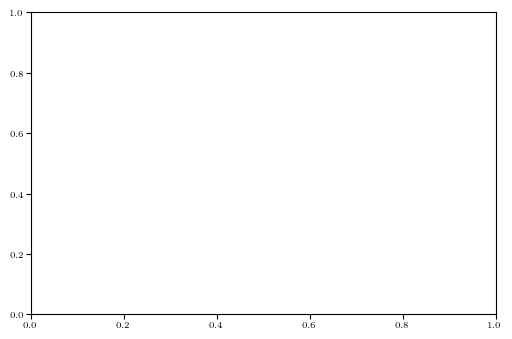

In [14]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()
    
    # allDFs_MCx, _ = get_full_monkey_data()
    # allDFs_M1, _ = get_full_mouse_data()

    
    plot_mouse_cca_corr(ax, allDFs_M1)
    plot_monkey_cca_corr(ax, allDFs_MCx[10:15])
    
    
    plt.show()

---

plot the within session trajectory correlations

In [15]:
@utility.report
def plot_traj_corr(ax, allDFs_MCx, AllDFs):
    try:
        os.chdir(params.repoPath / 'monkey')
        %run "_monkey-corr.ipynb"
        os.chdir(params.repoPath / 'mouse')
        %run "_mouse-corr.ipynb"
    finally:
        os.chdir(NBPath)

    within_corrs_monkeys = trim_within_monkey_corr (allDFs_MCx)
    within_corrs_mice = trim_within_mouse_corr (AllDFs)

    # plotting
    
    w_mice = list(within_corrs_mice.values())
    w_mice = np.array([l for L in w_mice for l in L])
    w_monkey = list(within_corrs_monkeys.values())
    w_monkey = np.array([l for L in w_monkey for l in L])
    ax.hist(w_mice,   density=True,alpha=.8,color=params.colors.MousePts, label=r'Mice')
    ax.hist(w_monkey, density=True,alpha=.8,color=params.colors.MonkeyPts, label=r'Monkeys')
    ax.axvline(w_mice.mean(), color=params.colors.MousePts, zorder=0)
    ax.axvline(w_monkey.mean(), color=params.colors.MonkeyPts, zorder=0)
    
    ax.set_yticks([])
    ax.set_xticks([0,1])
    ax.set_xlim([0,1])
    ax.tick_params(axis='x', direction='in')
    ax.set_ylabel('Probability\ndensity')
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_facecolor('None')

In [16]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot()
    
    # _, allDFs_MCx = get_full_monkey_data()
    # allDFs_M1, _ = get_full_mouse_data()

    plot_traj_corr(ax, allDFs_MCx[10:15], allDFs_M1)    
    
    plt.show()

Executed: `get_full_monkey_data` in 16.8s
Executed: `get_full_mouse_data` in 0.9s
Executed: `plot_traj_corr` in 1.1s


# Part 2
Plot figure

In [17]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    %matplotlib inline
    figsize=params.LargeFig
    fig=plt.figure(figsize=figsize)
    
   

    ##########################################
    # 1: schematics
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0, 
                                    bottom=figsize[1]-params.panels.schmatic[1], 
                                    width=params.panels.schmatic[0], 
                                    height=params.panels.schmatic[1])
    ax1   =fig.add_subplot(gs1[0])
    ax1 = utility.phantom_axes(ax1)
    ax1.set_facecolor([0,0,0,0])


    ##########################################
    # 2: Raster
    gs2_1 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=params.panels.schmatic[0],
                                     bottom=figsize[1]-params.panels.schmatic[1]+params.panels.velocity[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.raster[1])
    gs2_2 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     right=figsize[0],
                                     top=figsize[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.raster[1])
    
    gs2_3 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=params.panels.schmatic[0],
                                     bottom=figsize[1]-params.panels.schmatic[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.velocity[1])
    gs2_4 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     right=figsize[0],
                                     top=figsize[1]-params.panels.raster[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.velocity[1])

    
    raster_example_df = prep_example_df()
    
    axes2_1 = plot_moneky_fr_raster(raster_example_df[0], gs2_1)
    axes2_2 = plot_moneky_fr_raster(raster_example_df[1], gs2_2)
    utility.phantom_axes(fig.add_subplot(gs2_1[:])).set_title('Monkey $C_L$', pad=8)
    utility.phantom_axes(fig.add_subplot(gs2_2[:])).set_title('Monkey $M$', pad=8)
    
    axes2_3 = plot_moneky_vel_ex(raster_example_df[0], gs2_3)
    axes2_4 = plot_moneky_vel_ex(raster_example_df[1], gs2_4)

    axes2_3[0].set_ylabel('Position\n(centred)')
    axes2_3[0].set_xlabel('Time relative to movement onset',loc='left')
    X_line = mlines.Line2D([], [], color='blue', label='$X$')
    Y_line = mlines.Line2D([], [], color='red', label='$Y$')
    axes2_4[-1].legend(handles=[X_line, Y_line], loc=(1.1,.1))
        
    gs2_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, 
                                     height=params.panels.raster[1]-.15, 
                                     width=.1, 
                                     left=figsize[0]+.2, 
                                     bottom=figsize[1]-params.panels.schmatic[1]+params.panels.velocity[1])
    cax2 = fig.add_subplot(gs2_c[:])
    fig.colorbar(cm.ScalarMappable(),cax=cax2, ticks=(0,1),drawedges=False)
    cax2.set_title('Normalised\nfiring rate')


    
    
    ##########################################
    # 3: 3D projections
    gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=5, left=0, 
                                    bottom=figsize[1]-params.panels.schmatic[1]-params.panels.proj_3d_align[1]-.3,
                                    width=params.panels.proj_3d_align[0], 
                                    height=params.panels.proj_3d_align[1])

    
    axes3 = plot_monkey_pc_example(raster_example_df, gs3)
    
    
    gs3_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0,
                                    bottom=(axes3[0].get_position().y0+axes3[0].get_position().y1)/2*figsize[1],
                                    width=.2, height=0.2)
    cax3 = fig.add_subplot(gs3_c[0],zorder=10)

    utility.plot_targets(cax3,3)
    cax3.set_xlim(np.array(cax3.get_xlim())*1.15)
    cax3.set_ylim(np.array(cax3.get_ylim())*1.15)

    
    ##########################################
    # 4: CCA plot for the example animals
    gs4   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    left=0,
                                    bottom=gs3.bottom*figsize[1]-params.panels.cca[1]-.3, 
                                    width=params.panels.cca[0],
                                    height=params.panels.cca[1])

    ax4 = fig.add_subplot(gs4[0])
    
    plot_cca_for_ex(ax4)
    

    
    
    ##########################################
    # 5: CCA plot for population
    gs5 = fig.add_gridspec(nrows=1, ncols=2,  width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                           left=gs4.right+(.7/figsize[0]),  # .7" offset
                           right=gs4.right+ (.7/figsize[0]) + params.panels.cca_hist[0]/figsize[0],
                           bottom=gs4.bottom,
                           top=gs4.top,
                           wspace=0)

    ax5 = fig.add_subplot(gs5[0])
    ax5_ = fig.add_subplot(gs5[1])

    #TODO: legend shouldn't overlap with the histogram
    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca(ax5,ax5_, full_list_MCx, allDFs_MCx)
    
    
    
    ##########################################
    # 6: Decoding for monkeys
    gs6   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=gs5.top*figsize[1],
                                    right=figsize[0],
                                    width=params.panels.decoding_hist[0],
                                    height=params.panels.decoding_hist[1])

    ax6 = fig.add_subplot(gs6[0])

       
    plot_monkey_decoding(ax6, full_list_MCx, allDFs_MCx)

    
    
    ##########################################
    # 7: schematics Mouse
    gs7   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0, 
                                    bottom=gs6.bottom*figsize[1]-params.panels.schmatic[1],
                                    width=params.panels.schmatic[0],
                                    height=params.panels.cca[1])
    ax7   =fig.add_subplot(gs7[0])
    ax7 = utility.phantom_axes(ax7)
    ax7.set_facecolor([0,1,0,0])

    
    
    
    ##########################################
    # 8: CCA plot for MICE
    gs8 = fig.add_gridspec(nrows=1, ncols=2,  width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                           left=gs5.left,
                           right=gs5.right,
                           bottom=gs7.bottom,
                           top=gs7.top,
                           wspace=0)

    ax8 = fig.add_subplot(gs8[0])
    ax8_ = fig.add_subplot(gs8[1])
    
    
    allDFs_M1, _ = get_full_mouse_data()
    
    plot_mouse_cca(ax8,ax8_, allDFs_M1)
    
    
    
    ##########################################
    # 9: Behaviour vs CCA
    gs9   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=gs7.top*figsize[1],
                                    right=figsize[0],
                                    width=params.panels.neuro_behav_corr[0],
                                    height=params.panels.neuro_behav_corr[1])
    gs9_inset   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                                left=gs9.right*figsize[0]-.7,
                                                bottom=gs9.bottom*figsize[1]+.1,
                                                width=.7,
                                                height=params.panels.TinyH)
    ax9 = fig.add_subplot(gs9[0])
    ax9_ = fig.add_subplot(gs9_inset[0])


    
    plot_mouse_cca_corr(ax9, allDFs_M1)
    plot_monkey_cca_corr(ax9, allDFs_MCx)

    plot_traj_corr(ax9_, allDFs_MCx, allDFs_M1)


    
    
#     fig.align_ylabels([ax1,ax4])
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    AXES=(ax1,axes2_1[0],axes3[0],ax4,ax5,ax6,ax7,ax8,ax9)
    OFFX=np.array([.02]*len(AXES))
    OFFY=np.array([.01]*len(AXES))
    # OFFX[[-1]]=0.12
    OFFX[[0,2,3,4,5,6,7,8]]=0.05
    
    params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)
    
    fig.savefig(params.figPath / 'figure2.pdf', format='pdf', bbox_inches='tight')
    

    ##########################################
    # monkey schematics
 
    thisPath  =str(params.figPath / 'figure2.pdf')
    sketchPath=str(params.figPath / 'monkey-task-schematic.pdf')
    if os.path.exists(sketchPath):
        f1=ppdf.PdfFileReader(thisPath).getPage(0)
        f2=ppdf.PdfFileReader(sketchPath).getPage(0)

        f1.mergeTranslatedPage(page2=f2, tx=10, ty=347, expand=False)

        writer=ppdf.PdfFileWriter()
        writer.addPage(f1)
        with open(thisPath,'wb') as f3:
            writer.write(f3)



    ##########################################
    # mouse schematics
            
    thisPath  =str(params.figPath / 'figure2.pdf')
    sketchPath=str(params.figPath / 'mouse-task-schematic.pdf')
    if os.path.exists(sketchPath):
        f1=ppdf.PdfFileReader(thisPath).getPage(0)
        f2=ppdf.PdfFileReader(sketchPath).getPage(0)

        f1.mergeTranslatedPage(page2=f2, tx=10, ty=20, expand=False)

        writer=ppdf.PdfFileWriter()
        writer.addPage(f1)
        with open(thisPath,'wb') as f3:
            writer.write(f3)

Executed: `plot_moneky_fr_raster` in 0.1s
Executed: `plot_moneky_fr_raster` in 0.1s
Executed: `plot_moneky_vel_ex` in 0.2s
Executed: `plot_moneky_vel_ex` in 0.1s
Executed: `plot_monkey_pc_example` in 0.2s
Executed: `plot_cca_for_ex` in 4.5s
Executed: `get_full_monkey_data` in 17.3s
Executed: `plot_monkey_cca` in 201.0s
Executed: `plot_monkey_decoding` in 108.8s
Executed: `get_full_mouse_data` in 1.0s
Executed: `plot_mouse_cca` in 10.1s
Executed: `plot_mouse_cca_corr` in 7.2s
Executed: `plot_monkey_cca_corr` in 75.2s
Executed: `plot_traj_corr` in 1.2s
